In [1]:
%%capture
!pip install gymnasium
!pip install gymnasium[classic-control]

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import os
import datetime


import import_ipynb
from truly_plastic_p4 import plastic_nn
from truly_plastic_p4 import input_layer
from truly_plastic_p4 import layer

importing Jupyter notebook from truly_plastic_p4.ipynb


In [41]:

class replay_memory():
    def __init__(s, maxlen):
        s.memory = deque([], maxlen=maxlen)

    def append(s, transition):
        s.memory.append(transition)

    def sample(s, sample_size):
        return random.sample(s.memory, sample_size)

    def __len__(s):
        return len(s.memory)



class DQN():
   
    def __init__(s, ct = 0, tag=0, path = r'test', 
                 game_name = 'MountainCar-v0', 
                  
                 mini_batch_size = 32,  num_divisions = 1, 
                 replay_memory_size = 100000, 
                 network_sync_rate = 50000, discount_factor_g = 0.9):
        
        if (ct == 0):
            ct = datetime.datetime.now()
            ct = str(ct)
            ct = ct.replace(":", "-")
            ct = ct.replace(" ", "_")
            ct = ct[:-7]

        s.ct = ct
        current_directory = os.getcwd()
        final_directory_pics = os.path.join(current_directory, s.ct)
        
        final_directory_pics = os.path.join(final_directory_pics, 'pics')
        if not os.path.exists(final_directory_pics):
            os.makedirs(final_directory_pics)
        
        if (tag != 0):
            s.set_tag(tag)

        s.game_name = game_name
        s.discount_factor_g = discount_factor_g
         
        s.mini_batch_size = mini_batch_size 
        s.num_divisions = num_divisions

        # Divide position and velocity into segments
        s.lin_spaces = []
        env = gym.make(s.game_name)
        obs_space = env.observation_space

        for i in range(obs_space.shape[0]):
            s.lin_spaces.append(np.linspace(env.observation_space.low[i], env.observation_space.high[i], s.num_divisions))

        env.close()

        
        s.is_desrcete = False if num_divisions == 1 else False
        
        s.replay_memory_size =  replay_memory_size 
        s.network_sync_rate = network_sync_rate
        
    def set_tag(s, tag):
        s.tag = tag
        s.path = s.ct+'/'+s.tag
        current_directory = os.getcwd()
        final_directory = os.path.join(current_directory, s.path)
        if not os.path.exists(final_directory):
            os.makedirs(final_directory)
        
   
    def plot_progress(self, rewards_per_episode_, epsilon_history_):
        
        plt.figure()
        
        plt.xlabel('epochs')
        plt.ylabel('reward')
        plt.plot(rewards_per_episode_)

        plt.savefig(f'{self.path}/info_rew_{self.tag}.png'.format(self.path, self.tag))
        plt.savefig(f'{self.ct}/pics/info_rew_{self.tag}.png')
        plt.close()

        plt.figure()
        
        plt.xlabel('epochs')
        plt.ylabel('epsilon')
        plt.plot(epsilon_history_)
        plt.savefig(f'{self.path}/info_eps_{self.tag}.png'.format(self.path, self.tag))
        plt.close()

    
    def save_info(s, info):
        file_path = f'{s.path}/info_{s.tag}.txt'.format(s.path, s.tag)
        f = open(file_path, "a")   
       
        f.write("data {}\n".format(s.ct))
        f.write("tag {}\n".format(s.tag))
        f.write("game_name {}\n".format(s.game_name))
        f.write("reward discount factor {}\n".format(s.discount_factor_g))
        f.write("minibatch size {}\n".format(s.mini_batch_size))
        f.write("num divisions{}\n".format(s.num_divisions))
        f.write("replay memory size {}\n".format(s.replay_memory_size))
        f.write("network sync rate {}\n".format(s.network_sync_rate))
        f.write("info {}\n".format(info))
                         
        f.close()
    
    def add_log_data(s, data):
        file_path = f'{s.path}/info_{s.tag}.txt'.format(s.path, s.tag)
        f = open(file_path, "a") 
        f.write("{}\n".format(data))
                         
        f.close()
        
    def save_reward_data(s, data):
        file_path = f'{s.path}/rewards_{s.tag}.txt'.format(s.path, s.tag)
        f = open(file_path, "a") 
        f.write("{}\n".format(data))
                         
        f.close()



    
    def run_one_epoch(s, i):
        s.state = s.env.reset()[0] # seed = int(s.tag) + i
        s.terminated = False
        s.truncated = False
        s.rewards = 0

        while(not s.terminated and s.rewards < 300):# and s.rewards > -1000
            if random.random() < s.epsilon:
                s.action = s.env.action_space.sample()
            else:
                s.res = s.policy_dqn.forward(s.state_to_dqn_input(s.state))
                s.action = s.res.argmax().item()

            s.new_state, s.reward, s.terminated, s.truncated, _ = s.env.step(s.action)
            s.rewards += s.reward
            s.memory.append((s.state, s.action, s.new_state, s.reward, s.terminated))
            s.state = s.new_state
            
            s.step_count+=1
 
        
        if(s.terminated):
            s.goal_reached = True

        s.rewards_per_episode.append(s.rewards)
        
        
        if(i!=0 and i%1000==0): # Graph training progress
            print(f'Episode {i} Epsilon {s.epsilon}')
            
            s.policy_dqn.save(f'{s.path}/mc_policy_{i}'.format(s.path, i))
            s.add_log_data(f'Episode {i} Epsilon {s.epsilon}')
            
            s.plot_progress(s.rewards_per_episode, s.epsilon_history)

        
        if s.rewards > s.best_rewards:
            s.best_rewards = s.rewards
            
            print(f'Best rewards so far: {s.best_rewards}')
            s.add_log_data(f'Best rewards so far: {s.best_rewards}')
            s.policy_dqn.save(f'{s.path}/mc_policy_{i}'.format(s.path, i))
            s.policy_dqn.save(f'{s.path}/mc_policy_best'.format(s.path))
            

        if len(s.memory) > s.mini_batch_size and s.goal_reached: # if enough experience has been collected

            s.mini_batch = s.memory.sample(s.mini_batch_size)
            s.optimize(s.mini_batch)#, s.policy_dqn, s.target_dqn)

            # Decay epsilon
            s.epsilon = max(s.epsilon - 1/s.episodes, 0.01) 
            s.epsilon_history.append(s.epsilon)

            # Copy policy network to target network after a certain number of steps
            if s.step_count > s.network_sync_rate:
                s.target_dqn = s.policy_dqn.deep_copy()
                s.step_count = 0

        return s.rewards
    


    
    def init_train_data(s, policy_dqn, episodes):
        s.policy_dqn = policy_dqn
        s.target_dqn = plastic_nn()
        s.target_dqn = policy_dqn.deep_copy()

        
        s.epsilon = 1 # 1 = 100% random actions
        s.memory = replay_memory(s.replay_memory_size)

        s.rewards_per_episode = []
        s.epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        s.step_count = 0
        s.goal_reached = False
        s.best_rewards = -200 #-1000

        s.episodes = episodes 
        s.env = gym.make(s.game_name)

    
    def train(s, episodes):
        #s.init_train_data(policy_dqn, episodes)
        

        # main training
        for i in range(s.episodes+1):
            s.run_one_epoch(i)
        
        # # done
        # s.post_train()


    def post_train(s):
                
        s.env.close()
        s.policy_dqn.save(f'{s.path}/mc_policy_last_{s.tag}'.format(s.path, s.tag))
        
        if (s.best_rewards == -200): #update best -1000
            s.policy_dqn.save(f'{s.path}/mc_policy_best'.format(s.path))
            
        s.save_reward_data(s.rewards_per_episode)


    
    def optimize(s, mini_batch):
        s.target_q_list = []
        s.input_list = []
        
        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                s.target = reward
            else:
                s.target = reward + s.discount_factor_g * s.target_dqn.forward(s.state_to_dqn_input(new_state)).max()

            # Get the target set of Q values
            s.state_dsc = np.asarray(s.state_to_dqn_input(state))
            s.input_list.append(s.state_dsc)
            
            s.target_q = s.target_dqn.forward(s.state_dsc)
            
            # Adjust the specific action to the target that was just calculated
            s.target_q[action] = s.target            
            s.target_q_list.append(s.target_q)

        #BACKPOP AND UPDATE on minibatch
        x = np.asarray(s.input_list)
        x = x[:, :, 0]
        x = x.T

        y = np.asarray(s.target_q_list)
        y = y[:, :, 0]
        y = y.T

        s.policy_dqn.learn_one(x, y)



    def state_to_dqn_input(s, state):
        
        if (not s.is_desrcete):
            return np.asarray([state]).T
        else:
            d_state = []
            for i in range(state.shape[0]):
                dig = np.digitize(state[i], s.lin_spaces[i])
                d_state.append(np.asarray([dig]))
        
            return np.asarray(d_state)


        

    def test(self, policy_dqn, episodes, render = False):
        env = gym.make(self.game_name, render_mode='human' if render else None)
        
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        done_count = 0
        medium_reward = 0
        reward_list = []
        
        for i in range(episodes):
            state, info = env.reset() 
            done = False
            truncated = False 
            rewards = 0

            while(not done and not truncated):
                state = self.state_to_dqn_input(state)

                res = policy_dqn.forward(state)

                action = res.argmax().item()

                state, reward, done, truncated, _ = env.step(action)
                rewards+=reward
                if (truncated):
                    done_count += 1
                    break

            medium_reward += rewards
            reward_list.append(rewards)
                

        
        env.close()
        medium_reward = medium_reward / episodes
        return done_count*100.0/episodes, medium_reward, reward_list
        



## alg

In [4]:
import time

0
1
2
3
4
0
1
2
3
4
Episode 1000 Epsilon 1
Best rewards so far: -912.0
Episode 2000 Epsilon 0.691000000000034
Episode 1000 Epsilon 1
Episode 2000 Epsilon 1
Episode 1000 Epsilon 1
Best rewards so far: -773.0
Episode 2000 Epsilon 0.7260000000000302
Episode 1000 Epsilon 1
Best rewards so far: -577.0
Episode 2000 Epsilon 0.9230000000000085
Episode 1000 Epsilon 1
Best rewards so far: -779.0
Episode 2000 Epsilon 0.6595000000000375
0
1
2
3
4


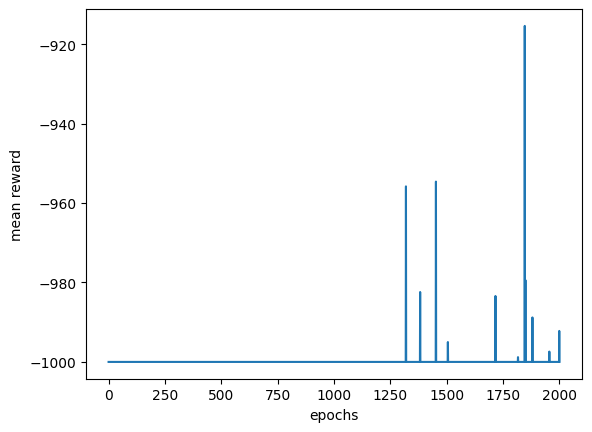

In [9]:
# learning_rate_a = 0.001
# game_name = "MountainCar-v0"
# env = gym.make(game_name)
# in_states = env.observation_space.shape[0]
# out_actions = env.action_space.n
# env.close()


# h1_nodes = 3
# h2_nodes = 2

# a_type1 = 'ReLU'
# a_type2 = 'Linear'


# num_of_nn = 5


# dqn_s = []


# ct = datetime.datetime.now()
# ct = str(ct)
# ct = ct.replace(":", "-")
# ct = ct.replace(" ", "_")
# ct = ct[:-7]

# for i in range(num_of_nn):
#     print(i)
#     layers_net = [input_layer(in_states), 
#     layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_type1), 
#     layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_type1), 
#     layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_type2)]
    
#     policy_dqn = plastic_nn(optimizer="Adam")
#     policy_dqn.append_layers(layers_net)
    
#     dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 50)
#     dqn_test.set_tag(str(i))
    
#     dqn_s.append(dqn_test)
#     #time.sleep(60)
    
# episodes = 2000

# for i in range (num_of_nn):
#     print(i)
#     dqn_s[i].init_train_data(policy_dqn, episodes)

# #mean_results = []
# summs = np.zeros(shape = episodes+1)
# for i in range (num_of_nn):
#     summ = 0
#     for e in range(episodes + 1):
#         summs[e] += dqn_s[i].run_one_epoch(e)
#     #mean_results.append(summ/num_of_nn)
#     #print(res)
        
# for i in range (num_of_nn):
#     print(i)
#     dqn_s[i].post_train()

# mean_results = summs / num_of_nn
# plt.figure()

# plt.xlabel('epochs')
# plt.ylabel('mean reward')
# plt.plot(mean_results)
# plt.show()
# plt.close()


0
1
2
3
4
Best rewards so far: 52.0
Best rewards so far: 9.0
Best rewards so far: 16.0
Best rewards so far: 37.0
Best rewards so far: 22.0
Best rewards so far: 23.0
Best rewards so far: 20.0
Best rewards so far: 58.0
Best rewards so far: 30.0
Best rewards so far: 25.0
Best rewards so far: 33.0
Best rewards so far: 38.0
Best rewards so far: 28.0
Best rewards so far: 29.0
Best rewards so far: 54.0
Best rewards so far: 38.0
Best rewards so far: 41.0
Best rewards so far: 62.0
Best rewards so far: 41.0
Best rewards so far: 64.0
Best rewards so far: 45.0
Best rewards so far: 54.0
Best rewards so far: 94.0
Best rewards so far: 69.0
Best rewards so far: 62.0
Best rewards so far: 65.0
Best rewards so far: 121.0
Best rewards so far: 64.0
Best rewards so far: 71.0
Best rewards so far: 67.0
Best rewards so far: 83.0
Best rewards so far: 115.0
Best rewards so far: 72.0
Best rewards so far: 97.0
Best rewards so far: 108.0
Best rewards so far: 84.0
Episode 1000 Epsilon 0.900100000000011
Episode 1000 

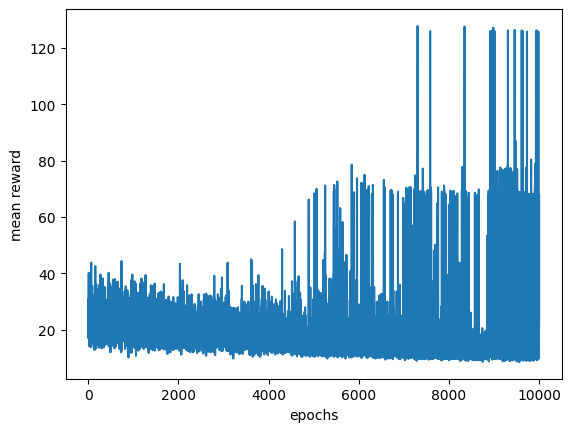

In [145]:
learning_rate_a = 0.2
game_name = "CartPole-v0"
env = gym.make(game_name)
in_states = env.observation_space.shape[0]
out_actions = env.action_space.n
env.close()


h1_nodes = 12
h2_nodes = 12

a_type1 = 'ReLU'
a_type2 = 'Linear'

a_types = [ '', 'ReLU', 'ReLU', 'Linear']

num_of_nn = 5


attempt_n = 1
for att in range(attempt_n):
    dqn_s = []
    
    
    ct = datetime.datetime.now()
    ct = str(ct)
    ct = ct.replace(":", "-")
    ct = ct.replace(" ", "_")
    ct = ct[:-7]
    ct = ct+'_'+str(att)
    for i in range(num_of_nn):
        print(i)
        layers_net = [input_layer(in_states), 
        layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_types[1]), 
        layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_types[2]), 
        layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_types[3])]
        topology = [in_states, h1_nodes, h2_nodes,  out_actions]
        policy_dqn = plastic_nn(optimizer="Adam")
        policy_dqn.append_layers(layers_net)
        
        dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 1)
        dqn_test.set_tag(str(i))
        dqn_test.save_info(f'lr: {learning_rate_a} \n{topology} \na:{a_types}\n')
        
        dqn_s.append(dqn_test)
        dqn_s[i].init_train_data(policy_dqn, episodes)
        #time.sleep(60)
        
    episodes = 10000
    
    summs = np.zeros(shape = episodes+1)

    # одномвременно
    for e in range(episodes + 1):
        for i in range (num_of_nn):  
            summs[e] += dqn_s[i].run_one_epoch(e)
    

    # последовательно
    # for i in range (num_of_nn):
    #     for e in range(episodes + 1):
    #         summs[e] += dqn_s[i].run_one_epoch(e)
            
    mean_results = np.asarray(summs) / num_of_nn
    
    for i in range (num_of_nn):
        print(i)
        dqn_s[i].post_train()
    
    
    plt.figure(att)
    
    plt.xlabel('epochs')
    plt.ylabel('mean reward')
    plt.plot(mean_results)
    plt.savefig(f'{dqn_s[0].ct}/mean.png')
    plt.show()
    plt.close()


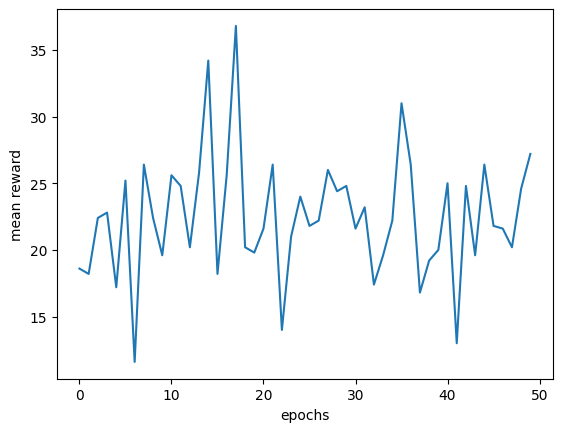

In [77]:
    plt.figure(att)
    
    plt.xlabel('epochs')
    plt.ylabel('mean reward')
    plt.plot(mean_results[:50])

    plt.show()
    plt.close()

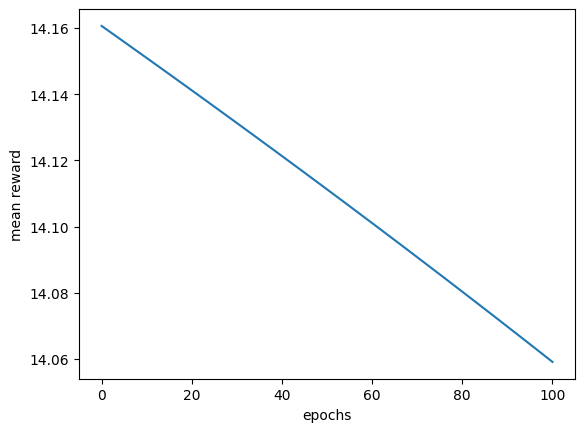

In [144]:
import copy
cpy_arr = copy.deepcopy(mean_results)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
for i in range(100):
    cpy_arr = moving_average(cpy_arr, 100)


plt.figure()

plt.xlabel('epochs')
plt.ylabel('mean reward')
plt.plot(cpy_arr)

plt.show()
plt.close()

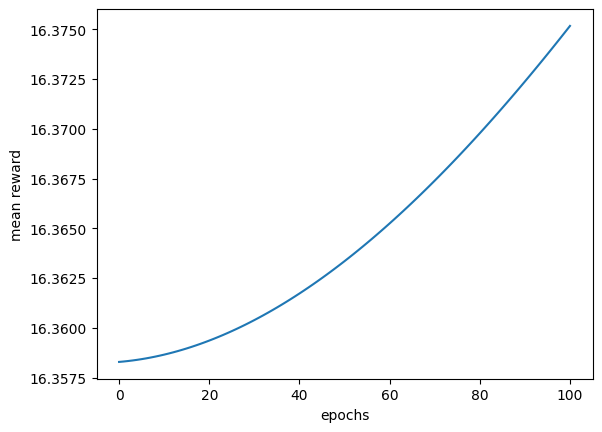

In [146]:
import copy
cpy_arr = copy.deepcopy(mean_results)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
for i in range(100):
    cpy_arr = moving_average(cpy_arr, 100)


plt.figure()

plt.xlabel('epochs')
plt.ylabel('mean reward')
plt.plot(cpy_arr)

plt.show()
plt.close()